# Data Analysis of self test by the authors

## Prerequisite

### Read in data

In [103]:
import pandas as pd

# Attempt to load the data using UTF-16 encoding, which may resolve encoding issues
variables_df = pd.read_csv('../data/variables_res-soft-class_2024-10-31_21-58.csv', delimiter=';', encoding='utf-16')
data_df = pd.read_csv('../data/data_res-soft-class_2024-10-31_21-46.csv', delimiter=';', encoding='utf-16')
values_df = pd.read_csv('../data/values_res-soft-class_2024-10-31_21-58.csv', delimiter=';', encoding='utf-16')


variables_labels = variables_df[['VAR', 'LABEL']].set_index('VAR').to_dict()['LABEL']
variables_labels_woPrefix = {var: label.replace("Category: ", "") for var, label in variables_labels.items()}


### Show Votes per Voter

In [104]:
category_columns = [col for col in data_df.columns if col.startswith('R001x')]

# Initialize a result dataframe to store each CASE, REF, and a list of categories marked as "2"
votes_summary = []

# Iterate over each row in the data to gather CASE, REF, and list of selected categories
for _, row in data_df.iterrows():
    case = row['CASE']
    ref = row['REF']
    selected_categories = []

    # Check each category column if it is marked with "2"
    for col in category_columns:
        if row[col] == 2:
            category_label = variables_labels_woPrefix.get(col, col)  # Get label if available, or fallback to column name
            selected_categories.append(category_label)

    # Append only if there are selected categories
    if selected_categories:
        votes_summary.append({
            'CASE': case,
            'REF': ref,
            'Selected_Categories': selected_categories
        })



# Convert the summary list into a DataFrame for easier display

votes_summary_df = pd.DataFrame(votes_summary)
votes_summary_df['DOI'] = data_df.set_index('CASE').loc[votes_summary_df['CASE'], 'R004_01'].values
votes_summary_df['Voter'] = data_df.set_index('CASE').loc[votes_summary_df['CASE'], 'R003'].values

votes_summary_df


,CASE,REF,Selected_Categories,DOI,Voter
0,70,NaN,"[Modelling, Simulation and Data Analytics, Mod...",10.21105/joss.07134,3
1,72,NaN,"[Modelling, Simulation and Data Analytics, Mod...",10.21105/joss.07134,9
2,73,NaN,"[Modelling, Simulation and Data Analytics, Dat...",10.21105/joss.06914,9
3,74,NaN,"[Research Infrastructure Software, Data Collec...",10.21105/joss.06914,2
4,75,NaN,[Technology Research Software],10.21105/joss.06825,2
...,...,...,...,...,...
238,399,NaN,"[Modelling, Simulation and Data Analytics, Mod...",10.21105/joss.02825,13
239,404,NaN,"[Technology Research Software, Software Related]",10.21105/joss.03465,13
240,405,NaN,"[Modelling, Simulation and Data Analytics, Mod...",10.21105/joss.03097,13
241,408,NaN,"[Modelling, Simulation and Data Analytics, Mod...",10.21105/joss.03097,1


## Summarize the Votes

### Unselected Categories

In [105]:
# Identifying all unique category labels that start with 'R001x' and comparing with selected categories

# Step 1: Identify all category columns that start with 'R001x' in data_df
all_category_vars = [col for col in data_df.columns if col.startswith('R001x')]

# Step 2: Get the labels for all these category variables from variables_labels dictionary
all_category_labels = set(variables_labels_woPrefix.get(var, var) for var in all_category_vars)

# Step 3: Gather all selected categories in votes_summary_df
selected_category_labels = set(category for sublist in votes_summary_df['Selected_Categories'] for category in sublist)

# Step 4: Identify categories that are present in all categories but not in selected categories
unselected_categories = all_category_labels - selected_category_labels

# Convert the result to a DataFrame for easy viewing
unselected_categories_df = pd.DataFrame({'Unselected_Categories': list(unselected_categories)})

unselected_categories_df

,Unselected_Categories
0,Laboratory Notebooks
1,Collaboration and Publication Software
2,Human Related


### Selected Votes

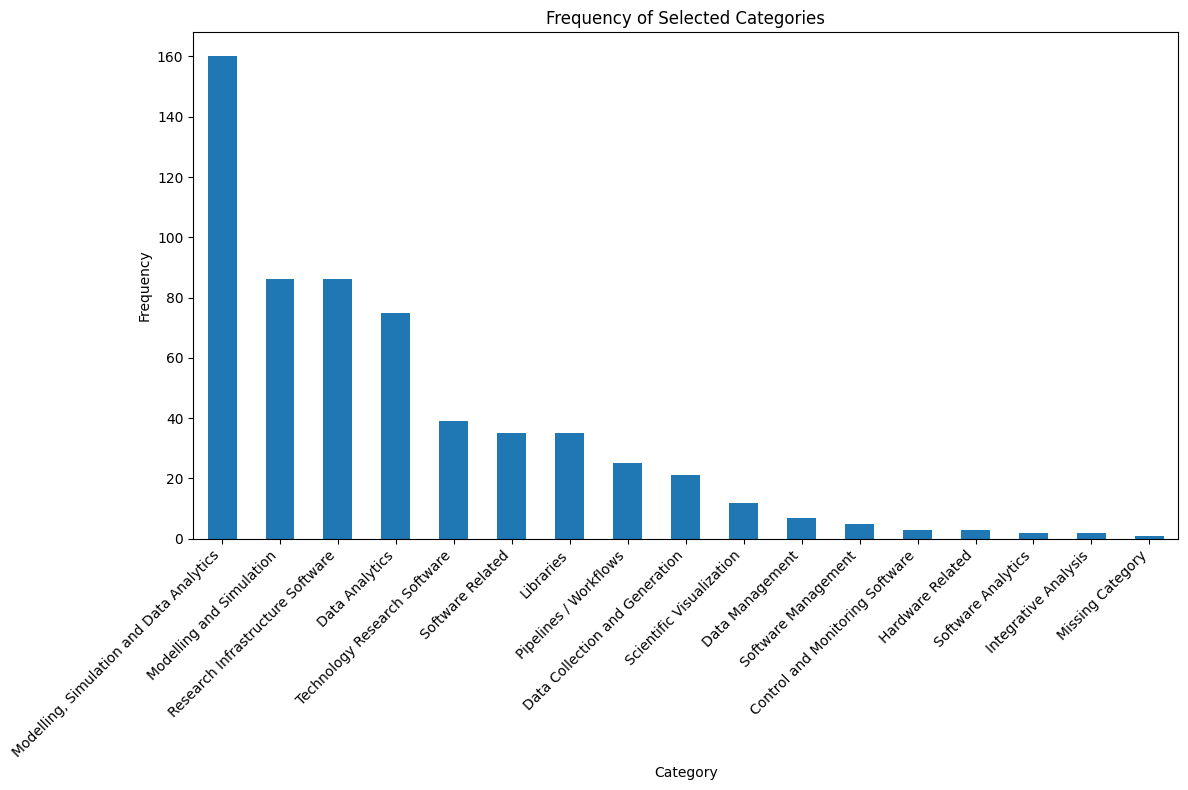

In [106]:
import matplotlib.pyplot as plt

# Flatten the list of selected categories for all votes and calculate frequency counts
all_selected_categories = [category for sublist in votes_summary_df['Selected_Categories'] for category in sublist]
selected_category_counts = pd.Series(all_selected_categories).value_counts()

# Re-plotting with English labels for clarity

# Plotting the frequency of each selected category
plt.figure(figsize=(12, 8))
selected_category_counts.plot(kind='bar')
plt.title('Frequency of Selected Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Aggregate Votes

* two/three votes are per paper
* these votes were aggregated to compare votes per paper

In [107]:
# Aggregating `votes_summary_df` by DOI, combining selected categories for duplicate DOIs in separate columns

# Group by DOI and collect selected categories for each vote as separate columns
aggregated_votes = votes_summary_df.groupby('DOI')['Selected_Categories'].apply(lambda x: pd.Series(x.values)).unstack()

# Rename columns to reflect each vote for the same DOI
aggregated_votes.columns = [f'Selected_Categories_Vote_{i+1}' for i in range(aggregated_votes.shape[1])]

# Reset index to make DOI a column and display the aggregated DataFrame
aggregated_votes.reset_index(inplace=True)

# Adding a column to check if all votes in Selected_Categories columns are identical or not

# Function to check if all selected categories across votes are identical for a row
def are_votes_identical(row):
    # Collect non-NaN votes as sets for each column and check if they are identical
    unique_votes = [set(vote) for vote in row if isinstance(vote, list) and vote]  # Ignore NaNs
    return 1 if len(set(map(frozenset, unique_votes))) == 1 else 0

# Apply this function across rows in the aggregated_votes DataFrame
aggregated_votes['Votes_Identical'] = aggregated_votes.apply(are_votes_identical, axis=1)

aggregated_votes

,DOI,Selected_Categories_Vote_1,Selected_Categories_Vote_2,Selected_Categories_Vote_3,Votes_Identical
0,10.21105/joss.01493,"[Research Infrastructure Software, Libraries]","[Research Infrastructure Software, Libraries]",NaN,1
1,10.21105/joss.01746,"[Technology Research Software, Software Relate...","[Research Infrastructure Software, Pipelines /...","[Technology Research Software, Software Related]",0
2,10.21105/joss.01904,"[Technology Research Software, Software Related]","[Modelling, Simulation and Data Analytics, Sof...",NaN,0
3,10.21105/joss.01956,"[Research Infrastructure Software, Pipelines /...","[Research Infrastructure Software, Libraries]",NaN,0
4,10.21105/joss.01981,"[Modelling, Simulation and Data Analytics, Dat...","[Modelling, Simulation and Data Analytics, Dat...",NaN,1
...,...,...,...,...,...
114,10.21105/joss.06914,"[Modelling, Simulation and Data Analytics, Dat...","[Research Infrastructure Software, Data Collec...",NaN,0
115,10.21105/joss.06932,"[Modelling, Simulation and Data Analytics, Mod...","[Research Infrastructure Software, Data Collec...",NaN,0
116,10.21105/joss.06940,"[Modelling, Simulation and Data Analytics, Mod...","[Modelling, Simulation and Data Analytics, Mod...",NaN,1
117,10.21105/joss.07031,"[Modelling, Simulation and Data Analytics, Dat...","[Modelling, Simulation and Data Analytics, Dat...",NaN,1


In [108]:
# Calculating an overview of the aggregated_votes DataFrame

# Total number of rows in aggregated_votes
total_elements = len(aggregated_votes)

# Count how many rows have 2 votes (non-NaN values) and how many have 3 votes
two_votes_count = aggregated_votes.dropna(subset=['Selected_Categories_Vote_1', 'Selected_Categories_Vote_2']).shape[0]
three_votes_count = aggregated_votes.dropna(subset=['Selected_Categories_Vote_1', 'Selected_Categories_Vote_2', 'Selected_Categories_Vote_3']).shape[0]

# Forming the summary sentence in English
summary_sentence = (
    f"The aggregated votes summary contains {total_elements} elements, "
    f"with {two_votes_count} entries having two votes and {three_votes_count} entries having three votes."
)

summary_sentence


'The aggregated votes summary contains 119 elements, with 119 entries having two votes and 5 entries having three votes.'

### Overlapping votes

In [109]:
# Counting occurrences of 0's and 1's in the 'Votes_Identical' column
votes_identical_counts = aggregated_votes['Votes_Identical'].value_counts()

# Displaying the counts of 0's and 1's in 'Votes_Identical'
votes_identical_counts


Votes_Identical
0    77
1    42
Name: count, dtype: int64